In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
BIM_FILE = '/n/holystore01/LABS/price_lab/Lab/ldsc/reference_files/1000G_EUR_Phase3/plink_files/1000G.EUR.QC.@.bim'
df_snp = None
for i_chr in range(1,23):
    temp_df = pd.read_csv(BIM_FILE.replace('@', '%d'%i_chr), sep='\t', header=None)
    if df_snp is None:
        df_snp = temp_df.copy()
    else:
        df_snp = pd.concat([df_snp, temp_df], axis=0)
df_snp.index = df_snp[1]
df_snp.columns = ['CHR', 'SNP', 'CM', 'BP', 'A1', 'A2']

In [3]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Lab/ldsc/sumstats_formatted'
DIC_SUMSTATS_NAME = {'RA': 'PASS_Rheumatoid_Arthritis.sumstats', 'SCZ':'PASS_Schizophrenia_Ruderfer2018.sumstats'}
dic_sumstats = {}
for term in DIC_SUMSTATS_NAME.keys():
    dic_sumstats[term] = pd.read_csv(DATA_PATH+'/'+DIC_SUMSTATS_NAME[term], sep='\t', index_col=0)
    dic_sumstats[term] = dic_sumstats[term].join(df_snp[['CHR', 'BP']])
    dic_sumstats[term] = dic_sumstats[term].loc[~dic_sumstats[term]['CHR'].isna()].copy()
    dic_sumstats[term].sort_values('CHR', inplace=True)

/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


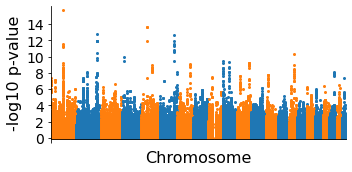

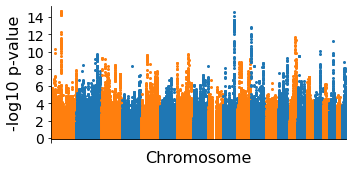

In [33]:
# Manhattan plot
OUT_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_schema'
dic_name = {'RA':'Rheumatoid arthritis', 'SCZ':'Schizophrenia'}
for term in DIC_SUMSTATS_NAME.keys():
    np.random.seed(0)
    
    df_plot = dic_sumstats[term].copy()
    df_plot['nlogp'] = -np.log10((1-stats.norm.cdf(np.absolute(df_plot['Z'])))*2)
    df_plot = df_plot.loc[df_plot['nlogp']<100]
    
    plt.figure(figsize=[5,2.5])
    ax = plt.subplot(1,1,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    pos_offset = 0
    chr_loc = []
    for i_chr in range(1,23):
        ind_select = df_plot['CHR']==i_chr
        plt.scatter(df_plot.loc[ind_select,'BP']+pos_offset, df_plot.loc[ind_select, 'nlogp'],
                    color='C%d'%(i_chr%2), s=4)
        chr_loc.append(pos_offset+df_plot.loc[ind_select,'BP'].max()*0.5)
        pos_offset += df_plot.loc[ind_select,'BP'].max()
    plt.xticks([0], [''])
    y_ticks = range(0, int(df_plot['nlogp'].max())+1, 2)
    plt.yticks(y_ticks, y_ticks, fontsize=14)
    plt.xlim([-1,pos_offset+1])
    plt.ylim([-0.1, df_plot['nlogp'].max()+0.5])
    plt.xlabel('Chromosome', fontsize=16)
    plt.ylabel('-log10 p-value', fontsize=16)
    plt.tight_layout()

    plt.savefig(OUT_PATH+'/gwas_%s.pdf'%term)
    plt.savefig(OUT_PATH+'/gwas_%s.png'%term)